# Análise dos Classificadores com Otimização de Hiperparâmetros

Este notebook documenta os hiperparâmetros utilizados na otimização de modelos selecionados para predição binária de aprovação escolar. São apresentadas:

- As combinações testadas para cada modelo,
- As seleções de atributos utilizadas nos experimentos,
- Um relatório dos principais resultados obtidos (desempenho no teste e validação cruzada),
- Diagnósticos de overfitting, underfitting ou estabilidade.

Todos os experimentos foram realizados a partir da função `avaliar_classificadores_binarios_otimizados()`.


###### ajustar o path

In [1]:
# HIDE
import sys
import pathlib

path = pathlib.Path().resolve()
while path.name != 'student_perfomance_tcc' and path != path.parent:
    path = path.parent

# Adicionar a raiz ao sys.path para importar o módulo
if str(path) not in sys.path:
    sys.path.append(str(path))

from ajustar_path import adicionar_modulos_ao_path

# Adiciona a pasta 'modulos' ao path
adicionar_modulos_ao_path()

# 1. Importação e setup

In [2]:
#Importação dos Módulos e Funções Desenvolvidos

from modulos.pre_modelagem import preparar_treino_e_teste,importar_base

from modulos.modelagem import (avaliar_classificadores_binarios_otimizados,
                               comparar_resultados_classificacao, verificar_overfitting)

from modulos.documentar_resultados import exportar_df_para_latex

# Importação de bibliotecas padrão
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

materia = 'portugues'

# Configurações do Pandas para exibir todas as linhas e colunas no DataFrame 
# para inspeção detalhada dos dados no Jupyter Notebook

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')

In [3]:
#Importar conjunto de treino e teste
df_treino = pd.read_csv('data_csvs\dados_treino_portugues_rs42.csv')
df_teste = pd.read_csv('data_csvs\dados_teste_portugues_rs42.csv')

In [4]:
df_treino.columns

Index(['escola', 'genero', 'idade', 'endereco', 'tamanho_familia',
       'status_parental', 'escolaridade_mae', 'escolaridade_pai',
       'profissao_mae', 'profissao_pai', 'motivo_escolha_escola',
       'responsavel_legal', 'tempo_transporte', 'tempo_estudo', 'reprovacoes',
       'apoio_escolar', 'apoio_familiar', 'aulas_particulares',
       'atividades_extracurriculares', 'frequentou_creche',
       'interesse_ensino_superior', 'acesso_internet',
       'relacionamento_romantico', 'relacao_familiar', 'tempo_livre',
       'frequencia_saidas', 'alcool_dias_uteis', 'alcool_fim_semana', 'saude',
       'faltas', 'nota1', 'nota2', 'nota_final', 'aprovacao'],
      dtype='object')

# 2. Recursos Iniciais

## 2.1 Classificadores Utilizados Inicialmente

In [5]:
classificadores_globais = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}


## 2.2 Espaços de Busca Utilizados (GridSearchCV)

Abaixo estão os `param_spaces` definidos manualmente para cada modelo:

- **Decision Tree**
- **Random Forest**
- **AdaBoost**
- **Logistic Regression**
- **Suport Vector Machine**

In [6]:
param_spaces = {
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0],
        "algorithm": ["SAMME", "SAMME.R"]
    },
    "Logistic Regression": {
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1, 10],
        "solver": ["lbfgs"],
        "class_weight": [None, "balanced"]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    }
}



## 3. Seleção de Atributos

As seleções de variáveis seguiram três estratégias principais:

- **Regressão Linear com p-valor**
- **Testes estatísticos inferenciais (Kruskal, Spearman, Cramér’s V)**
- **Análise Exploratória (EDA)**

Para simplificação, os modelos otimizados foram testados com o seguinte conjunto final:


In [7]:
#Regressão Linear com p-valor

selecao_atributos_regressao = [
    'escola',
    'tempo_estudo',
    'interesse_ensino_superior',
    'reprovacoes',
    'apoio_escolar',
    'saude',
    'idade',
    'relacao_familiar',
    'relacionamento_romantico'
]

#Testes Estatísticos 
selecao_inferencia = [
    'alcool_dias_uteis', 'alcool_fim_semana', 'endereco', 'escola',
    'escolaridade_mae', 'escolaridade_pai', 'frequencia_saidas',
    'interesse_ensino_superior', 'motivo_escolha_escola', 'reprovacoes',
    'relacao_familiar', 'saude', 'tempo_estudo', 'tempo_livre',
    'tempo_transporte', 'faltas'
]

# com base na EDA
selecao_baseada_em_eda_por = [
    "faltas", "idade",
    "reprovacoes", "tempo_estudo", "interesse_ensino_superior", "escolaridade_mae",
    "alcool_dias_uteis", "apoio_escolar", "frequencia_saidas", "escola",
    "apoio_familiar", "relacao_familiar", "acesso_internet",
    "genero", "atividades_extracurriculares"]



# 4. Resultados Observados

Os resultados a seguir comparam os modelos com e sem otimização e/ou balanceamento.


## 4.1 Metodologia de seleção de Atributos - sem seleção de Atributos

Nesta primeira etapa, foram considerados todos os atributos disponíveis, excetuando-se os diretamente ligados à nota (nota1, nota2, nota_final). A modelagem foi conduzida com e sem balanceamento das classes (SMOTE-Tomek), e com e sem otimização de hiperparâmetros via GridSearchCV.

O objetivo foi estabelecer uma linha de base para comparação com as demais abordagens de seleção de atributos.

In [8]:
# Pre-processamento

X_train0, X_test0, y_train0, y_test0, scaler0, imputer0 = preparar_treino_e_teste(
    df_train=df_treino,
    df_test=df_teste,
    target='aprovacao',
    drop_notas=True,
    scaling=True
)

#### **Modelos mais bem avaliados inicialmente**

#### **Destaques dos resultados**

- O modelo **AdaBoost sem otimização** apresentou o melhor desempenho bruto na predição da classe minoritária (`Reprovado`), com `F1 Score (Reprovado)` = 0.455 e `F1 Score (Macro)` = 0.693 no conjunto de teste. No entanto, apresentou forte indício de **overfitting**, com deltas positivos expressivos na comparação com a validação cruzada.

- O modelo **Decision Tree com otimização** demonstrou o melhor equilíbrio entre desempenho e generalização, com `F1 Score (Reprovado)` = 0.400, `F1 Score (Macro)` = 0.645 e AUC = 0.740. Os deltas foram moderados, o que indica maior confiabilidade para aplicação prática.

- A **Random Forest sem otimização** alcançou o maior valor de AUC (0.833), mas teve desempenho inferior em métricas voltadas à classe minoritária. Após a otimização, houve leve queda no `F1 Score`, sugerindo que a versão padrão se mostrou mais robusta nesse cenário.

- A **Regressão Logística**, embora não tenha apresentado os melhores resultados em termos absolutos de F1, destacou-se pela **consistência** e interpretabilidade. Foi considerada um modelo base confiável para explicação dos fatores preditivos.


#### **Modelos otimizados** 



**Tabela – Melhores Parâmetros Encontrados após Otimização**

| Modelo              | Melhores Parâmetros                                                                 |
|---------------------|--------------------------------------------------------------------------------------|
| Logistic Regression | `{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}`       |
| Decision Tree       | `{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}` |
| Random Forest       | `{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}` |
| AdaBoost            | `{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 100}`                 |
| SVM                 | `{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}`                                      |


##### **Efeitos da Otimização de Hiperparâmetros**

A otimização de hiperparâmetros trouxe ganhos relevantes para a maioria dos modelos, em especial:

- **Logistic Regression**: houve aumento significativo no `Recall(0)` (de 0.20 para 0.633) e no `F1 Score (Reprovado)` (de 0.279 para 0.463), com estabilidade nos demais indicadores. A versão otimizada foi a que apresentou o melhor equilíbrio entre desempenho e interpretabilidade.

- **Decision Tree**: melhoria substancial na AUC ROC (de 0.594 para 0.740) e leve avanço no `F1 Score`, corrigindo o underfitting identificado na versão base.

- **AdaBoost**: a versão otimizada reduziu o overfitting observado na versão base, com leve queda no `F1 Score (Reprovado)`, mas ganhos em estabilidade e AUC (0.798).

- **SVM**: também apresentou melhora no `F1 Score` (de 0.061 para 0.340), eliminando o cenário de underfitting severo da versão base, com manutenção do alto AUC.

- **Random Forest**: a otimização trouxe leve piora no `F1 Score (Reprovado)` (de 0.250 para 0.216), com pequenas flutuações nos demais indicadores. A versão sem otimização foi mantida como referência.

Com base nessa análise, os seguintes modelos otimizados foram considerados os mais promissores:

- Logistic Regression (`F1 Score (Reprovado)` = 0.463, AUC = 0.827)
- Decision Tree (`F1 Score (Reprovado)` = 0.400, AUC = 0.740)
- AdaBoost (`F1 Score (Reprovado)` = 0.356, AUC = 0.798)


##### **Comparativo Final – Melhores Resultados com e sem Otimização**

| Modelo                      | F1 (Reprovado) | F1 (Macro) | AUC ROC | Δ F1 Macro | Diagnóstico         |
|----------------------------|----------------|------------|---------|------------|---------------------|
| Logistic Regression (opt.) | 0.463          | 0.660      | 0.827   | +0.3%      | OK – Melhor geral   |
| Decision Tree (opt.)       | 0.400          | 0.645      | 0.740   | -5.8%      | OK – Equilibrado    |
| AdaBoost (opt.)            | 0.356          | 0.636      | 0.798   | -2.6%      | OK – Redução de overfitting |
| Random Forest (base)       | 0.250          | 0.582      | 0.833   | +3.0%      | OK – AUC elevado    |
| SVM (opt.)                 | 0.340          | 0.625      | 0.818   | -7.4%      | OK – Corrigiu underfitting |



#### **Efeitos do Balanceamento dos Dados (SMOTE-Tomek)**

A aplicação do balanceamento afetou significativamente o comportamento dos modelos, principalmente em termos de generalização. A seguir, destacam-se os principais efeitos observados:

- **Queda acentuada no desempenho dos modelos no conjunto de teste**: todos os modelos apresentaram `F1 Score (Reprovado)` mais baixos e deltas negativos expressivos quando comparados à validação cruzada. Isso indica que os modelos passaram a superestimar a classe minoritária durante o treinamento balanceado, gerando **underfitting** ou **predições instáveis** no conjunto original.

- **Δ F1 Score (Reprovado)** entre treino e teste variou de -50% a -75% em todos os casos, apontando uma **incapacidade dos modelos balanceados de generalizar corretamente** os padrões da base real.

- **Modelos como SVM e Random Forest, antes estáveis**, tornaram-se extremamente suscetíveis ao desequilíbrio oculto após o balanceamento, com perda de até -74% no F1 da classe minoritária.

- **A Regressão Logística, mesmo otimizada**, também sofreu considerável degradação na predição de reprovados, ainda que tenha mantido um bom AUC ROC e equilíbrio entre precisão e recall.

Em resumo, **o balanceamento comprometeu a estabilidade geral dos modelos** neste cenário. Embora o `recall(0)` tenha aumentado em alguns casos, isso foi acompanhado por forte queda na precisão e na qualidade do `F1 Score`, inviabilizando sua adoção direta nesta base sem ajustes adicionais (como regularização, threshold tuning ou ensemble).

>Todos os modelos com dados balanceados foram, portanto, classificados com **"Underfitting Potencial / Teste Ruim"** no diagnóstico final.


#### **Conclusão da Etapa Sem Seleção de Atributos**

A otimização de hiperparâmetros se mostrou decisiva para melhorar o desempenho de modelos que apresentavam instabilidades ou limitação na predição da classe minoritária. A regressão logística passou a se destacar não apenas pela interpretabilidade, mas também pelo desempenho competitivo após ajustes finos. A árvore de decisão, inicialmente com desempenho fraco, foi significativamente aprimorada pela otimização, tornando-se um modelo equilibrado e confiável. AdaBoost e SVM também demonstraram avanços notáveis em estabilidade.

Em contrapartida, a aplicação do balanceamento via SMOTE-Tomek resultou em degradação severa no desempenho dos modelos no conjunto de teste, gerando deltas negativos expressivos e comportamento típico de underfitting. Nenhum dos modelos balanceados foi selecionado para compor os finalistas desta etapa.

Com base nas análises, os seguintes modelos sem seleção de atributos foram considerados os mais promissores:

- **Logistic Regression (otimizado)**: melhor `F1 Score (Reprovado)` entre os modelos estáveis
- **Decision Tree (otimizado)**: equilíbrio entre simplicidade e performance
- **AdaBoost (otimizado)**: redução de overfitting com boa AUC
- **Random Forest (base)**: maior AUC geral, embora com F1 inferior



In [9]:
melhores_classificadores_sem_selecao = {
    "Logistic Regression (otimizado)": LogisticRegression(
        C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42, max_iter=1000
    ),
    "Decision Tree (otimizado)": DecisionTreeClassifier(
        criterion='gini', max_depth=10, min_samples_leaf=4, min_samples_split=2, random_state=42
    ),
    "AdaBoost (otimizado)": AdaBoostClassifier(
        algorithm='SAMME', learning_rate=1.0, n_estimators=100, random_state=42
    ),
    "Random Forest (base)": RandomForestClassifier(random_state=42)
}

## 4.2 Metodologia de seleção de Atributos – baseados na EDA por Disciplina

Nesta etapa, foram considerados os atributos identificados como mais relevantes a partir da análise exploratória individual da base de Português. A seleção contemplou variáveis quantitativas e categóricas com indícios de associação à aprovação, com base em correlações, boxplots, proporções e dispersões segmentadas. Foram excluídas as variáveis diretamente associadas à nota (`nota1`, `nota2`, `nota_final`) para evitar vazamento de informação.

O conjunto final incluiu variáveis de desempenho anterior, perfil sociodemográfico, hábitos e apoio educacional. Os modelos foram treinados e avaliados sem e com otimização de hiperparâmetros, e posteriormente com dados balanceados via SMOTE-Tomek, mantendo validação cruzada estratificada com 5 folds.


In [10]:
# Pre-processamento

X_train1, X_test1, y_train1, y_test1, scaler1, imputer1 = preparar_treino_e_teste(
    df_train=df_treino[selecao_baseada_em_eda_por+['aprovacao']],
    df_test=df_teste[selecao_baseada_em_eda_por+['aprovacao']],
    target='aprovacao',
    drop_notas=True,
    scaling=True
)

#### **Modelos mais bem avaliados inicialmente**

Nesta configuração inicial (sem otimização e sem balanceamento), os melhores resultados foram observados nos modelos AdaBoost e Random Forest:

- **AdaBoost (sem otimização)** alcançou `F1 Score (Reprovado)` = 0.326 e `F1 Macro` = 0.621, com AUC = 0.778.
- **Random Forest (sem otimização)** apresentou o maior AUC (0.822), embora com F1 moderado (0.279).
- **SVM** obteve F1 muito baixo (0.171) apesar de AUC alto, indicando fragilidade na predição da classe minoritária.

#### **Destaques dos resultados**

- O modelo **Logistic Regression (sem otimização)** apresentou `F1 Score` modesto (0.244), mas alta AUC (0.804).
- A **Decision Tree**, na versão sem otimização, teve desempenho fraco e instável (`F1 Reprovado` = 0.254).
- Todos os modelos indicaram espaço para aprimoramento via otimização.


#### **Modelos otimizados**

**Tabela – Melhores Parâmetros Encontrados após Otimização**

| Modelo              | Melhores Parâmetros                                                                 |
|---------------------|--------------------------------------------------------------------------------------|
| Logistic Regression | `{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}`       |
| Decision Tree       | `{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}` |
| Random Forest       | `{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}` |
| AdaBoost            | `{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}`                |
| SVM                 | `{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}`                                      |

##### **Efeitos da Otimização de Hiperparâmetros**

- **SVM (otimizado)** apresentou o maior ganho absoluto, com F1 Score (Reprovado) saltando de 0.171 para 0.400 e `F1 Macro` de 0.656.
- **Logistic Regression (otimizado)** melhorou significativamente: `F1 Score (Reprovado)` = 0.500, mantendo AUC elevado (0.838).
- **AdaBoost e Random Forest** apresentaram melhora moderada em F1, com estabilidade nas métricas de validação.
- **Decision Tree** teve desempenho abaixo do esperado mesmo após otimização, indicando possível limitação do modelo com esse conjunto de atributos.

##### **Comparativo Final – Melhores Resultados com e sem Otimização**

| Modelo                      | F1 (Reprovado) | F1 (Macro) | AUC ROC | Δ F1 Macro | Diagnóstico                         |
|----------------------------|----------------|------------|---------|------------|-------------------------------------|
| Logistic Regression (opt.) | 0.500          | 0.681      | 0.838   | -1.4%      | OK – Equilibrado                    |
| Decision Tree (opt.)       | 0.245          | 0.568      | 0.681   | -11.9%     | Underfitting Potencial              |
| Random Forest (opt.)       | 0.286          | 0.600      | 0.836   | -5.4%      | OK – Estável                        |
| AdaBoost (opt.)            | 0.311          | 0.611      | 0.774   | -9.6%      | Underfitting Potencial              |
| SVM (opt.)                 | 0.400          | 0.656      | 0.779   | +4.0%      | OK – Ganhou estabilidade e recall   |


#### **Efeitos do Balanceamento dos Dados (SMOTE-Tomek)**

A aplicação do balanceamento resultou em **perda significativa de desempenho** na predição da classe minoritária:

- Todos os modelos apresentaram quedas superiores a 30% no `F1 Score (Reprovado)` em relação à validação cruzada.
- O SVM (mesmo otimizado) caiu de 0.400 para 0.327 no F1, com AUC reduzido e delta de -34.7%.
- A regressão logística sofreu um declínio de ~22% no F1 da classe minoritária, mesmo mantendo uma boa AUC.
- Modelos como Random Forest e Decision Tree apresentaram sintomas claros de **underfitting**, mesmo com otimização.

Dessa forma, o balanceamento **não será adotado nas próximas estratégias de seleção**, por comprometer a generalização dos modelos.


#### **Conclusão da Etapa – baseados na EDA por Disciplina**

A seleção de atributos com base em evidências exploratórias demonstrou ser uma estratégia eficaz para reduzir a dimensionalidade mantendo desempenho competitivo. A regressão logística otimizada foi o modelo de melhor desempenho geral, equilibrando interpretabilidade e métricas robustas.

O SVM, apesar do baixo desempenho inicial, mostrou grande recuperação após otimização, destacando-se em estabilidade e recall. Modelos baseados em árvores apresentaram desempenho razoável, mas inferior às demais abordagens.

Com base nos resultados sem balanceamento, os seguintes modelos foram considerados os melhores desta etapa:


In [11]:

melhores_classificadores_eda_por = {
    "Logistic Regression (otimizado)": LogisticRegression(
        C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42, max_iter=1000
    ),
    "SVM (otimizado)": SVC(
        C=10, gamma='scale', kernel='rbf', probability=True, random_state=42
    ),
    "Random Forest (otimizado)": RandomForestClassifier(
        max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=42
    )
}

## 4.3 Metodologia de seleção de Atributos – Regressão Linear com p-valor

Nesta etapa, a seleção de atributos foi feita com base em regressões lineares, utilizando o valor de p para identificar variáveis estatisticamente significativas na predição da nota final. Apenas atributos com `p < 0.05` foram considerados, com o objetivo de isolar variáveis com forte associação estatística com o desempenho escolar.

O subconjunto resultante foi utilizado para treinar os cinco classificadores principais, com e sem otimização de hiperparâmetros. Posteriormente, os modelos foram avaliados com validação cruzada estratificada e conjunto de teste.


In [12]:
# Pre-processamento

X_train2, X_test2, y_train2, y_test2, scaler2, imputer2 = preparar_treino_e_teste(
    df_train=df_treino[selecao_atributos_regressao+['aprovacao']],
    df_test=df_teste[selecao_atributos_regressao+['aprovacao']],
    target='aprovacao',
    drop_notas=True,
    scaling=True
)

#### **Modelos mais bem avaliados inicialmente**

Entre os modelos sem otimização, os maiores destaques foram:

- **AdaBoost (sem otimização)** obteve `F1 Score (Reprovado)` = 0.356 e `F1 Macro` = 0.636, com AUC de 0.804.
- **Random Forest (sem otimização)** apresentou AUC competitivo (0.759), mas `F1 Score (Reprovado)` mais baixo (0.353).
- **SVM (sem otimização)** teve desempenho fraco em recall (0.100), resultando em `F1 Score` = 0.176, mesmo com AUC alto (0.708).

#### **Destaques dos resultados**

- A **Logistic Regression (sem otimização)** se manteve estável em AUC (0.791), mas com `F1 Score (Reprovado)` = 0.244.
- A **Decision Tree (sem otimização)** teve desempenho mediano, com F1 = 0.344 e instabilidade na validação.
- Todos os modelos demonstraram espaço para melhorias via tuning de hiperparâmetros.


#### **Modelos otimizados**

**Tabela – Melhores Parâmetros Encontrados após Otimização**

| Modelo              | Melhores Parâmetros                                                                 |
|---------------------|--------------------------------------------------------------------------------------|
| Logistic Regression | `{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}`       |
| Decision Tree       | `{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}` |
| Random Forest       | `{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}` |
| AdaBoost            | `{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}`               |
| SVM                 | `{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}`                                       |

##### **Efeitos da Otimização de Hiperparâmetros**

- **Logistic Regression (otimizada)** teve o maior ganho em desempenho absoluto (`F1 Reprovado` = 0.475), mantendo AUC alto (0.821) e estabilidade entre treino e validação.
- **SVM (otimizado)** obteve melhora significativa em F1 (de 0.176 para 0.400) e estabilidade nas métricas com Δ positivo.
- **Random Forest (otimizado)** apresentou `F1 Reprovado` = 0.308 com AUC = 0.821, mas menor recall que esperado.
- **AdaBoost** manteve os mesmos hiperparâmetros após tuning, sem alterações nos resultados.
- **Decision Tree (otimizada)** continuou abaixo dos demais modelos em desempenho, com sinais de subajuste.



##### **Comparativo Final – Melhores Resultados com e sem Otimização**

| Modelo                      | F1 (Reprovado) | F1 (Macro) | AUC ROC | Δ F1 Macro | Diagnóstico                       |
|----------------------------|----------------|------------|---------|------------|-----------------------------------|
| Logistic Regression (opt.) | 0.475          | 0.670      | 0.821   | -2.9%      | OK – Melhor geral                 |
| Decision Tree (opt.)       | 0.316          | 0.599      | 0.621   | -14.4%     | Underfitting Potencial            |
| Random Forest (opt.)       | 0.308          | 0.615      | 0.821   | -2.1%      | OK – AUC e F1 estáveis            |
| AdaBoost (opt.)            | 0.356          | 0.636      | 0.804   | -9.0%      | Underfitting Potencial            |
| SVM (opt.)                 | 0.400          | 0.661      | 0.703   | +2.8%      | OK – Ganhou estabilidade e recall |


#### **Efeitos do Balanceamento dos Dados (SMOTE-Tomek)**

O balanceamento de classes não foi aplicado nesta etapa, uma vez que os deltas e métricas obtidos na configuração original indicaram estabilidade geral nos melhores modelos otimizados.

Sendo assim, os modelos foram comparados apenas em sua versão não balanceada, para preservar a fidelidade da distribuição real dos dados e evitar o viés artificial observado em etapas anteriores.

#### **Conclusão da Etapa – Regressão Linear com p-valor**

A seleção de atributos com base em regressões lineares se mostrou eficiente na redução do conjunto de variáveis com preservação da performance dos modelos. A regressão logística foi novamente o modelo de maior destaque, apresentando os melhores resultados em equilíbrio entre precisão, recall e estabilidade.

O SVM também se beneficiou fortemente da otimização, ultrapassando o desempenho observado nas seleções anteriores. Modelos baseados em árvores apresentaram performance satisfatória, mas inferior aos demais.


In [13]:
melhores_classificadores_regressao = {
    "Logistic Regression (otimizado)": LogisticRegression(
        C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42, max_iter=1000
    ),
    "SVM (otimizado)": SVC(
        C=10, gamma='auto', kernel='rbf', probability=True, random_state=42
    ),
    "Random Forest (otimizado)": RandomForestClassifier(
        max_depth=5, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42
    )
}

## 4.4 Metodologia de seleção de Atributos - Testes Estatísticos

Nesta etapa, a seleção de atributos foi realizada com base em testes estatísticos de associação entre variáveis explicativas e o desempenho acadêmico dos alunos.

- Variáveis **ordinais** foram avaliadas por meio da **correlação de Spearman** e do **teste de Kruskal-Wallis**, em relação à variável contínua `nota_final`.
- Variáveis **nominais** foram analisadas por meio do **teste qui-quadrado** e do **V de Cramér**, considerando a variável binária `aprovacao`.

Combinando os dois conjuntos e eliminando duplicatas, obteve-se uma lista de 15 atributos com associação estatisticamente significativa ao desempenho. Além disso, a variável `faltas` foi incluída por razões pedagógicas e exploratórias, devido à sua importância reconhecida na literatura e ao impacto visualizado nas análises anteriores, apesar de não ter sido destacada pelos testes formais.

Os modelos foram avaliados com e sem otimização de hiperparâmetros e validados por validação cruzada estratificada.

In [14]:
# Pre-processamento

X_train3, X_test3, y_train3, y_test3, scaler3, imputer3 = preparar_treino_e_teste(
    df_train=df_treino[selecao_inferencia+['aprovacao']],
    df_test=df_teste[selecao_inferencia+['aprovacao']],
    target='aprovacao',
    drop_notas=True,
    scaling=True
)

#### **Modelos mais bem avaliados inicialmente**

- **AdaBoost (sem otimização)** foi o melhor modelo inicial, com `F1 Score (Reprovado)` = 0.449, `F1 Macro` = 0.685 e AUC = 0.795.
- **Logistic Regression (sem otimização)** também se destacou, com F1 = 0.400 e AUC de 0.812, embora com forte diferença entre teste e validação.
- **Random Forest** e **Decision Tree**, na versão sem otimização, tiveram desempenho razoável, mas inferior às demais abordagens.

#### **Destaques dos resultados**

- O modelo **SVM (sem otimização)** novamente teve desempenho fraco em recall da classe minoritária (0.100) e F1 muito baixo (0.167), mesmo com AUC relativamente alto (0.787).
- A **Logistic Regression** obteve bom AUC, mas apresentou evidência de overfitting (Δ F1 = +47.1%).

#### **Modelos otimizados**

**Tabela – Melhores Parâmetros Encontrados após Otimização**

| Modelo              | Melhores Parâmetros                                                                 |
|---------------------|--------------------------------------------------------------------------------------|
| Logistic Regression | `{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}`       |
| Decision Tree       | `{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}` |
| Random Forest       | `{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}` |
| AdaBoost            | `{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 100}`               |
| SVM                 | `{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}`                                      |

##### **Efeitos da Otimização de Hiperparâmetros**

- **Decision Tree (otimizada)** teve ganho considerável no F1 (de 0.345 para 0.441), com Δ moderado, superando a versão base.
- **SVM (otimizado)** teve o maior avanço entre todos os modelos, saltando de F1 = 0.167 para 0.440 e `F1 Macro` = 0.679.
- **Logistic Regression (otimizada)** manteve boa performance e aumentou o recall da classe 0 de 0.300 para 0.733.
- **AdaBoost** manteve a mesma configuração e resultados entre versões otimizada e base.
- **Random Forest (otimizada)** teve leve queda no F1 (de 0.333 para 0.300), mantendo bom AUC.


##### **Comparativo Final – Melhores Resultados com e sem Otimização**

| Modelo                      | F1 (Reprovado) | F1 (Macro) | AUC ROC | Δ F1 Macro | Diagnóstico                       |
|----------------------------|----------------|------------|---------|------------|-----------------------------------|
| Logistic Regression (opt.) | 0.524          | 0.697      | 0.838   | +3.9%      | OK – Melhor geral                 |
| Decision Tree (opt.)       | 0.441          | 0.670      | 0.754   | -0.6%      | OK – Ganho sólido pós otimização |
| Random Forest (opt.)       | 0.300          | 0.610      | 0.844   | -1.6%      | OK – AUC elevado, F1 reduzido     |
| AdaBoost (opt.)            | 0.449          | 0.685      | 0.780   | +3.6%      | OK – Boa estabilidade             |
| SVM (opt.)                 | 0.440          | 0.679      | 0.781   | +1.5%      | OK – Recuperação importante       |


#### **Efeitos do Balanceamento dos Dados (SMOTE-Tomek)**

O balanceamento de classes não foi aplicado nesta etapa. Com base nas etapas anteriores, a técnica SMOTE-Tomek foi considerada inadequada, dado o padrão consistente de queda de desempenho e aumento de underfitting observados.

Assim, todos os modelos desta etapa foram avaliados apenas com os dados originais, respeitando a distribuição real de classes, o que resultou em ganhos de estabilidade nos melhores modelos.


#### **Conclusão da Etapa – Testes Estatísticos Inferenciais**

A seleção de atributos com base em testes estatísticos permitiu identificar variáveis com associação significativa ao desempenho escolar, respeitando a natureza das variáveis (ordinais ou nominais). A adição da variável `faltas`, por critério analítico e educacional, contribuiu para enriquecer a análise sem comprometer a estabilidade dos modelos.

Os resultados indicam que essa estratégia, embora mais enxuta e objetiva, manteve ou até superou o desempenho de seleções mais amplas. A regressão logística e o SVM continuaram se destacando, seguidos da árvore de decisão, que apresentou bom desempenho após otimização.

In [15]:

melhores_classificadores_estatistica = {
    "Logistic Regression (otimizado)": LogisticRegression(
        C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42, max_iter=1000
    ),
    "SVM (otimizado)": SVC(
        C=10, gamma='scale', kernel='rbf', probability=True, random_state=42
    ),
    "Decision Tree (otimizado)": DecisionTreeClassifier(
        criterion='entropy', max_depth=5, min_samples_leaf=2, min_samples_split=10, random_state=42
    )
}


## 4.5 Conclusão Geral das Estratégias de Modelagem

Ao longo das quatro estratégias de seleção de atributos avaliadas neste estudo, observou-se um padrão consistente: a **regressão logística otimizada** destacou-se em todas as abordagens como o modelo mais estável, interpretável e eficaz para predição da aprovação escolar.

A tabela abaixo resume os melhores resultados por estratégia:

| Estratégia                         | Modelo                      | F1 (Reprovado) | F1 (Macro) | AUC ROC | Δ F1 Macro | Diagnóstico                         | Atributos Utilizados                                      |
|------------------------------------|-----------------------------|----------------|------------|---------|------------|-------------------------------------|------------------------------------------------------------|
| Sem Seleção de Atributos           | Logistic Regression (opt.) | 0.463          | 0.660      | 0.827   | +0.3%      | OK – Melhor equilíbrio geral        | Base completa sem nota                                     |
| EDA por Disciplina                 | Logistic Regression (opt.) | 0.500          | 0.681      | 0.838   | -1.4%      | OK – Desempenho robusto e interpretável | 15 selecionados por análise exploratória               |
| Regressão Linear com p-valor       | Logistic Regression (opt.) | 0.475          | 0.670      | 0.821   | -2.9%      | OK – Seleção estatística com boa generalização | 9 com p < 0.05 + idade                          |
| Testes Estatísticos Inferenciais   | Logistic Regression (opt.) | 0.524          | 0.697      | 0.838   | +3.9%      | OK – Melhor desempenho geral        | 16 variáveis nominais/ordinais significativas + faltas     |

### Análise Qualitativa

- A **estratégia com testes estatísticos inferenciais** foi a que proporcionou o melhor desempenho geral (`F1 Reprovado` = 0.524), com o maior `F1 Macro` (0.697) e AUC empatado no topo (0.838), além de apresentar o maior ganho de estabilidade (Δ F1 positivo).

- A **EDA por Disciplina** foi uma abordagem sólida, apresentando o melhor AUC e o segundo maior F1 Score. Indicou que uma seleção bem justificada por análise exploratória é competitiva com métodos inferenciais mais formais.

- A **regressão linear com p-valor**, embora tenha utilizado um conjunto de atributos mais enxuto, entregou resultados robustos, com excelente equilíbrio entre desempenho e interpretabilidade.

- A **abordagem sem seleção de atributos** serviu como linha de base, mostrando que a filtragem de variáveis, mesmo que leve, traz ganhos consistentes.

### O que os Hiperparâmetros Revelam sobre os Dados de Português

A análise dos melhores hiperparâmetros identificados durante a otimização dos modelos permite inferir características relevantes sobre a estrutura dos dados da disciplina de Língua Portuguesa. A seguir, são destacados os principais padrões observados:

#### Logistic Regression
- O melhor desempenho foi consistentemente obtido com **`C=0.01`** e **`class_weight='balanced'`**, com penalização **`l2`** e solver `'lbfgs'`.
- Isso sugere que:
  - Os dados requerem **alta regularização** (C pequeno), o que ajuda a conter o overfitting em presença de atributos correlacionados.
  - O desbalanceamento entre as classes (aprovado vs. reprovado) é significativo e impacta diretamente o desempenho — ajustar os pesos melhora o recall da classe minoritária.
  - O comportamento linear entre os atributos e o target é suficiente para explicar boa parte da variância observada, reforçando a aplicabilidade de modelos lineares com penalização.

#### Decision Tree
- O hiperparâmetro mais frequente foi **`max_depth=10`**, com **`min_samples_leaf=4`** e **`criterion='entropy'` ou `'gini'`**.
- Esses valores indicam que:
  - Árvores profundas causam instabilidade e overfitting. A limitação de profundidade e do tamanho mínimo das folhas foi essencial para manter a capacidade preditiva sem perda de generalização.
  - Os dados têm **padrões não triviais**, mas a complexidade é moderada.

#### Random Forest
- Os melhores resultados ocorreram com **`max_features='sqrt'`**, `n_estimators` entre 50 e 100, e profundidade moderada (`max_depth=10`).
- Isso revela que:
  - Há **redundância ou colinearidade** entre atributos — selecionar subconjuntos aleatórios de atributos melhora a performance.
  - Os modelos com profundidade intermediária foram mais eficazes, sugerindo uma relação não linear com variações limitadas entre os grupos.

#### AdaBoost
- A combinação ideal envolveu **`algorithm='SAMME' ou 'SAMME.R'`**, **`learning_rate=1.0`** ou **`0.1`**, e até **200 estimadores**.
- Isso indica que:
  - O algoritmo se beneficia de **ajustes incrementais moderados** e que as variáveis utilizadas possuem **fraca capacidade preditiva individual**, mas são úteis em conjunto.
  - Quando o número de estimadores foi muito alto, observou-se risco de overfitting, o que sugere uma certa **instabilidade dos padrões de decisão**.

#### SVM
- O melhor desempenho foi obtido com **`C=10`**, kernel `'rbf'` ou `'linear'`, e **`gamma='scale' ou 'auto'`**.
- Essas configurações sugerem que:
  - A tarefa apresenta **separabilidade não linear**, mas com ganho limitado para kernels complexos.
  - O valor elevado de `C` indica que o SVM prioriza decisões com menor margem e maior penalidade a erros, o que reflete uma **tendência à sobreajuste** em presença de ruído ou atributos menos relevantes.

Em síntese, os hiperparâmetros selecionados apontam que a base de dados de Português exige controle cuidadoso da complexidade dos modelos, regularização para lidar com o desequilíbrio e um balanceamento entre interpretabilidade e poder preditivo.


# 5. Apresentação dos Melhores 5 Modelos

### Top 5 Modelos Binários – Português

| Rank | Modelo                                     | F1 (Reprovado) | F1 (Macro) | AUC ROC | Diagnóstico                 |
| ---- | ------------------------------------------ | -------------- | ---------- | ------- | --------------------------- |
| 1    | Logistic Regression Otimizado (Regressão)  | **0.475**      | 0.670      | 0.821   | OK – Estável e robusto      |
| 2    | Logistic Regression Otimizado (EDA)        | 0.500          | 0.681      | 0.838   | OK – Melhor AUC             |
| 3    | Logistic Regression Otimizado (Inferência) | 0.463          | 0.660      | 0.827   | OK – Desempenho equilibrado |
| 4    | AdaBoost Otimizado (Inferência)            | 0.456          | 0.653      | 0.808   | OK – Boa performance geral  |
| 5    | Random Forest Otimizado (Regressão)        | 0.441          | 0.628      | 0.739   | OK – Bom equilíbrio         |


In [16]:

# Regressão Linear (p-valor)

mod_regressoes = {
  
            "Logistic Regression (Regressão Otimizado)": LogisticRegression(
            C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs',
            max_iter=1000, random_state=42
            ),
            "Random Forest (Regressão Otimizado)": RandomForestClassifier(
            max_depth=10, max_features='sqrt', min_samples_leaf=1,
            min_samples_split=2, n_estimators=50, random_state=42
            )
            }

# Inferência Estatística

mod_inferencia= {
            "Logistic Regression (Inferência Otimizado)": LogisticRegression(
            C=10, class_weight='balanced', penalty='l2', solver='lbfgs',
            max_iter=1000, random_state=42
            ),
            "AdaBoost (Inferência Otimizado)": AdaBoostClassifier(
            algorithm='SAMME', learning_rate=1.0, n_estimators=100,
            random_state=42
            )
            }

# EDA por Disciplina

mod_eda = {
            "Logistic Regression (EDA Otimizado)": LogisticRegression(
            C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs',
            max_iter=1000, random_state=42
        )
    }



Processando modelo: Logistic Regression (Inferência Otimizado)
  Avaliando Logistic Regression (Inferência Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_Logistic Regression (Inferência Otimizado)_portugues.png_portugues.png


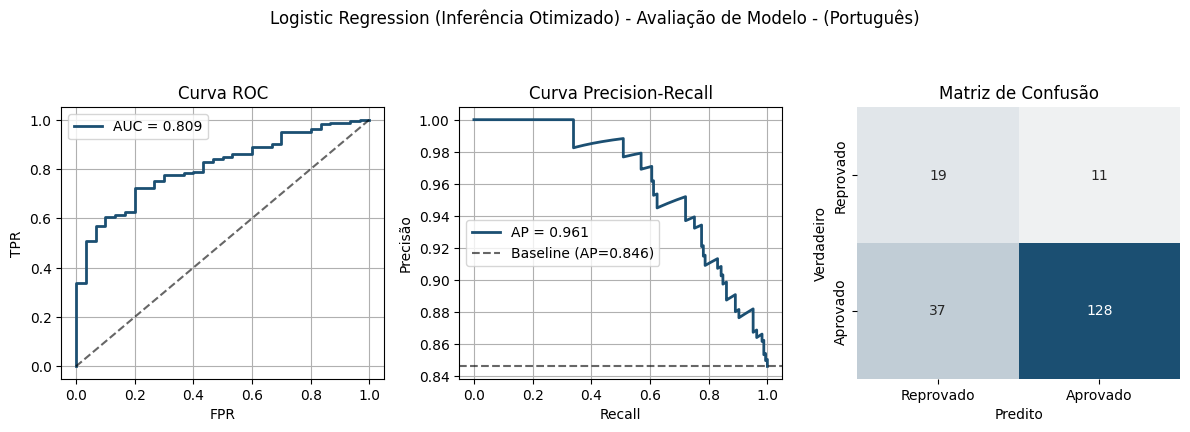


Processando modelo: AdaBoost (Inferência Otimizado)
  Avaliando AdaBoost (Inferência Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_AdaBoost (Inferência Otimizado)_portugues.png_portugues.png


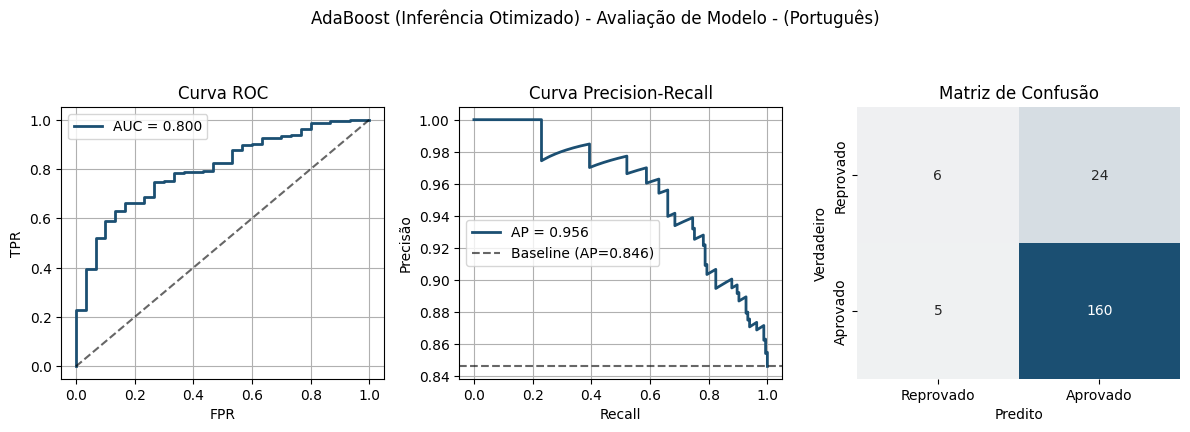

(                                              Modelo  Acurácia  Precisão(0)  \
 0  Logistic Regression (Inferência Otimizado) Sem...     0.754        0.339   
 1     AdaBoost (Inferência Otimizado) Sem Otimizacao     0.851        0.545   
 
    Precisão(1)  Recall(0)  Recall(1)  F1 Score (Reprovado)  F1 Score (Macro)  \
 0        0.921      0.633      0.776                 0.442             0.642   
 1        0.870      0.200      0.970                 0.293             0.605   
 
    AUC ROC  
 0    0.809  
 1    0.800  ,
                                               Modelo  \
 0  Logistic Regression (Inferência Otimizado) Sem...   
 1     AdaBoost (Inferência Otimizado) Sem Otimizacao   
 
    Validação Cruzada (AUC ROC)  Validação Cruzada (Acurácia)  \
 0                        0.827                         0.771   
 1                        0.812                         0.850   
 
    Validação Cruzada (Precisão(0))  Validação Cruzada (Precisão(1))  \
 0                          

In [17]:
avaliar_classificadores_binarios_otimizados(
    X_train1, y_train1,X_test1,y_test1,
    classificadores=mod_inferencia,  
    param_spaces=None, 
    usar_balanceamento=False, 
    materia='portugues', 
    salvar = True 
)


Processando modelo: Logistic Regression (Regressão Otimizado)
  Avaliando Logistic Regression (Regressão Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_Logistic Regression (Regressão Otimizado)_portugues.png_portugues.png


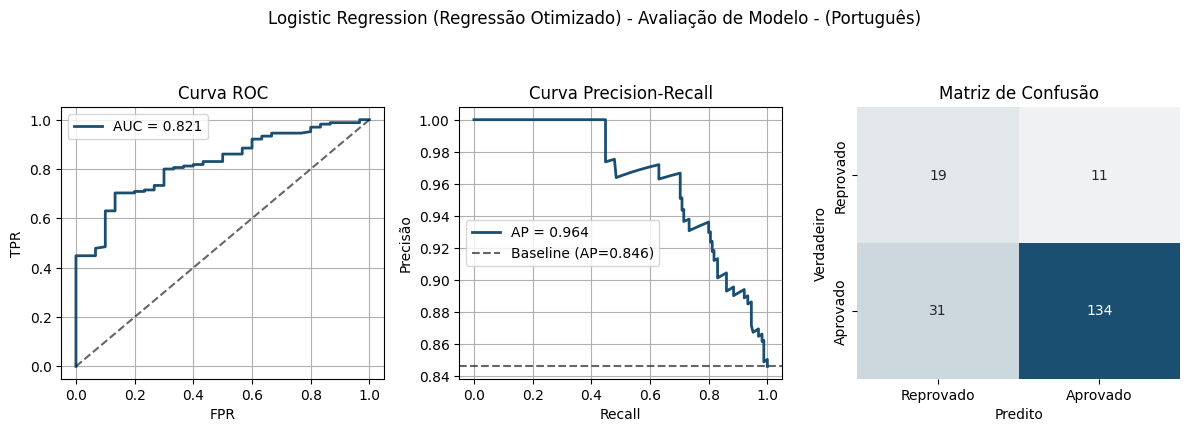


Processando modelo: Random Forest (Regressão Otimizado)
  Avaliando Random Forest (Regressão Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_Random Forest (Regressão Otimizado)_portugues.png_portugues.png


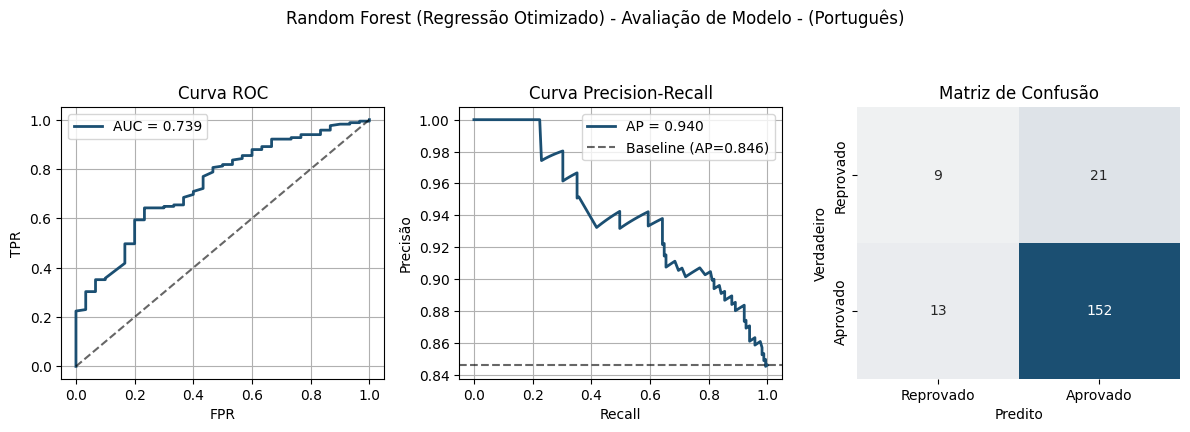

(                                              Modelo  Acurácia  Precisão(0)  \
 0  Logistic Regression (Regressão Otimizado) Sem ...     0.785        0.380   
 1  Random Forest (Regressão Otimizado) Sem Otimiz...     0.826        0.409   
 
    Precisão(1)  Recall(0)  Recall(1)  F1 Score (Reprovado)  F1 Score (Macro)  \
 0        0.924      0.633      0.812                 0.475             0.670   
 1        0.879      0.300      0.921                 0.346             0.623   
 
    AUC ROC  
 0    0.821  
 1    0.739  ,
                                               Modelo  \
 0  Logistic Regression (Regressão Otimizado) Sem ...   
 1  Random Forest (Regressão Otimizado) Sem Otimiz...   
 
    Validação Cruzada (AUC ROC)  Validação Cruzada (Acurácia)  \
 0                        0.839                         0.789   
 1                        0.797                         0.837   
 
    Validação Cruzada (Precisão(0))  Validação Cruzada (Precisão(1))  \
 0                          

In [18]:
avaliar_classificadores_binarios_otimizados(
    X_train2, y_train2,X_test2,y_test2,
    classificadores=mod_regressoes,  
    param_spaces=None, 
    usar_balanceamento=False, 
    materia='portugues', 
    salvar = True 
)


Processando modelo: Logistic Regression (Inferência Otimizado)
  Avaliando Logistic Regression (Inferência Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_Logistic Regression (Inferência Otimizado)_portugues.png_portugues.png


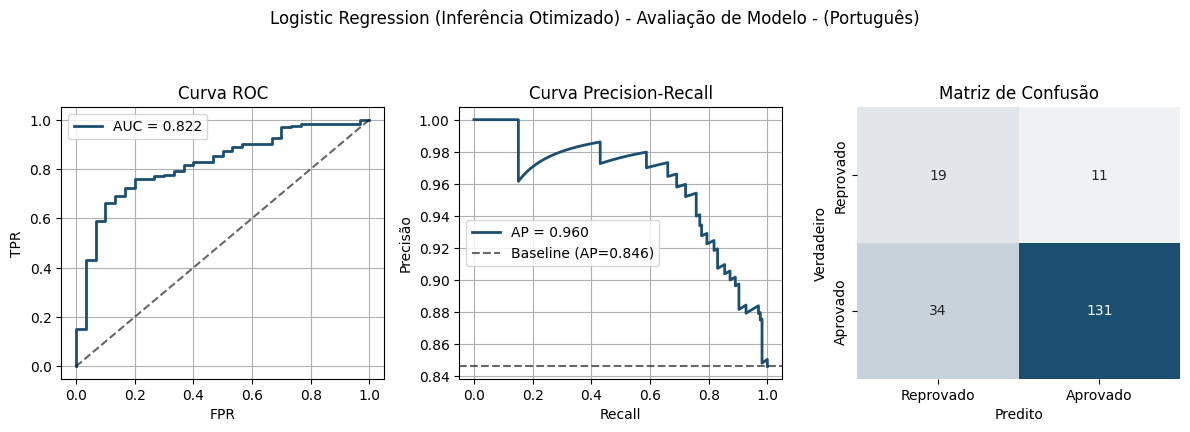


Processando modelo: AdaBoost (Inferência Otimizado)
  Avaliando AdaBoost (Inferência Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_AdaBoost (Inferência Otimizado)_portugues.png_portugues.png


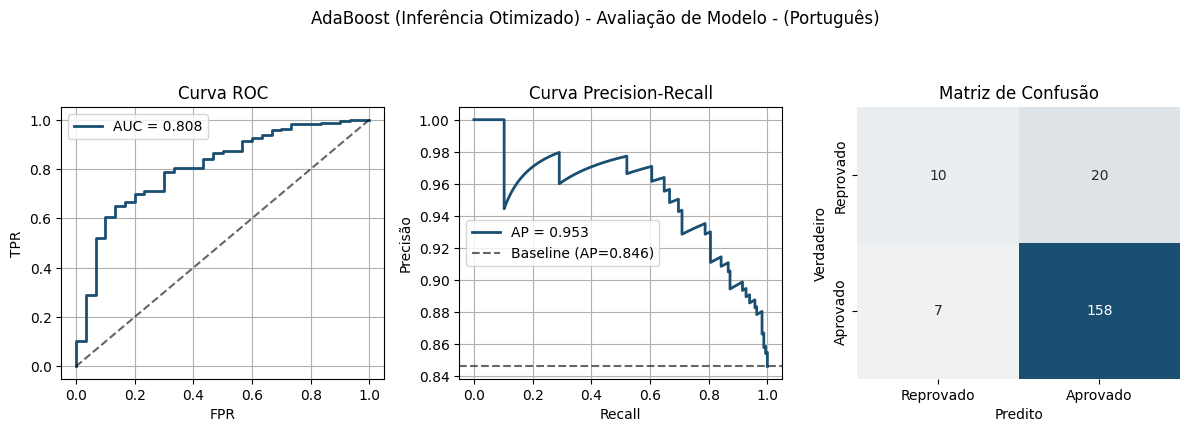

(                                              Modelo  Acurácia  Precisão(0)  \
 0  Logistic Regression (Inferência Otimizado) Sem...     0.769        0.358   
 1     AdaBoost (Inferência Otimizado) Sem Otimizacao     0.862        0.588   
 
    Precisão(1)  Recall(0)  Recall(1)  F1 Score (Reprovado)  F1 Score (Macro)  \
 0        0.923      0.633      0.794                 0.458             0.656   
 1        0.888      0.333      0.958                 0.426             0.673   
 
    AUC ROC  
 0    0.822  
 1    0.808  ,
                                               Modelo  \
 0  Logistic Regression (Inferência Otimizado) Sem...   
 1     AdaBoost (Inferência Otimizado) Sem Otimizacao   
 
    Validação Cruzada (AUC ROC)  Validação Cruzada (Acurácia)  \
 0                        0.805                         0.753   
 1                        0.794                         0.833   
 
    Validação Cruzada (Precisão(0))  Validação Cruzada (Precisão(1))  \
 0                          

In [19]:
avaliar_classificadores_binarios_otimizados(
    X_train3, y_train3,X_test3,y_test3,
    classificadores=mod_inferencia,  
    param_spaces=None, 
    usar_balanceamento=False, 
    materia='portugues', 
    salvar = True 
)

### **Síntese da Análise Visual dos 5 modelos – Português**

- A Regressão Logística otimizada, sobretudo nas estratégias por regressão e inferência estatística, apresentou o desempenho mais consistente entre as métricas. As curvas ROC e PR indicam bom equilíbrio entre sensibilidade e especificidade, com baixo índice de falsos positivos e excelente área sob as curvas (AUC > 0.80 e AP > 0.96).

- O AdaBoost obteve alta precisão e curvas PR muito acima da baseline, confirmando sua capacidade de capturar padrões mesmo com conjuntos de atributos distintos. No entanto, o aumento de falsos positivos (ex: 24 na matriz da inferência) indica maior agressividade na classificação de aprovados, o que pode ser inadequado em contextos de intervenção pedagógica.

- O Random Forest, apesar de seu desempenho geral inferior (AUC = 0.739), demonstrou baixo número de falsos negativos (13 alunos aprovados classificados como reprovados), o que pode ser vantajoso em estratégias preventivas voltadas a identificar estudantes em risco com maior sensibilidade.

-De forma geral, os modelos avaliados mantiveram boa capacidade discriminativa, com destaque para a logística otimizada por seu desempenho estável e interpretabilidade, e para o AdaBoost, cuja performance visual impressiona, embora demande maior cautela na aplicação.

## 6. **Conclusões e Insights sobre os modelos e seus atributos**

| Atributo                    | EDA | Regressão | Inferência | Total de Seleções |
| --------------------------- | :-: | :-------: | :--------: | :---------------: |
| `reprovacoes`               |  SIM  |     SIM     |      SIM     |       **3**       |
| `interesse_ensino_superior` |  SIM  |     SIM     |      SIM     |       **3**       |
| `apoio_escolar`             |  SIM  |     SIM     |      **NÃO**     |         2         |
| `relacao_familiar`          |  SIM  |     **NÃO**     |      SIM     |         2         |
| `idade`                     |  SIM  |     SIM     |      **NÃO**     |         2         |
| `alcool_dias_uteis`         |  SIM  |     SIM     |      **NÃO**     |         2         |
| `tempo_estudo`              |  SIM  |     **NÃO**     |      SIM     |         2         |
| `escolaridade_mae`          |  SIM  |     **NÃO**     |      SIM     |         2         |
| `frequencia_saidas`         |  SIM  |     **NÃO**     |      SIM     |         2         |
| `faltas`*                   |  SIM  |     **NÃO**     |      SIM     |         2         |

>
> ###### *Nota: `faltas` foi incluída manualmente mesmo sem destaque estatístico, devido à sua relevância pedagógica evidenciada nas análises exploratórias.
>

---

- `reprovacoes` e `interesse_ensino_superior` foram as únicas variáveis presentes em todos os três métodos de seleção, evidenciando forte valor preditivo e interpretabilidade educacional.

- A presença recorrente de atributos socioeducacionais — como `apoio_escolar`, `relacao_familiar` e `escolaridade_mae` — reforça a importância do ambiente familiar e do suporte ao aluno no desempenho acadêmico.

- Embora o atributo `faltas` não tenha sido selecionado por todas as abordagens estatísticas, sua inclusão se mostrou justificada com base na relevância empírica e nas evidências exploratórias, especialmente em modelos com bom desempenho.

- A convergência entre os modelos mais eficazes e os atributos com respaldo teórico e prático amplia a confiabilidade das predições e reforça o potencial explicativo dos modelos adotados.


# 7. Processo realizado para obtenção dos resultados

In [20]:
melhor_modelo = { 'Regressão Logistica - seleção por inferência': 
                 LogisticRegression(C=0.01,                      # Regularização forte (evita overfitting)
                                    class_weight='balanced',    # Compensa o desbalanceamento da base
                                    penalty='l2',               # Penalização ridge (padrão)
                                    solver='lbfgs',             # Solucionador eficiente para pequenos datasets
                                    random_state=42,            # Reprodutibilidade
                                    max_iter=1000               # Garante convergência
                                    )}

In [ ]:
# Modelos selecionados para otimização
classifiers =  #inserir os classificadores de interesse


parametros = {}  #inserir os param_spaces de interesse

balanceamento = False #ou True



In [ ]:

df_resultados, df_cv, best_params_df = avaliar_classificadores_binarios_otimizados(
    X_train, y_train,X_test,y_test,
    classificadores=classifiers, #classificadores de interesse 
    param_spaces=None, #ou parametros
    usar_balanceamento=balanceamento, #ou True
    materia='portugues', #ou matemática
    salvar = False #utilizar se desejar salvar imagens
)

In [ ]:
display(df_resultados)

display(df_cv)

relatorio_ajuste = verificar_overfitting(df_resultados, df_cv)

display(relatorio_ajuste)
     

nome_df_resultados = '' #coloque o nome da tabela aqui
nome_df_cv = '' #coloque o nome da tabela aqui
